In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

In [2]:
model_spec = {
    "classes" : ["S", "I"],

    "S" : {
        "constant"  : [ ["k"] ], 
        "infection" : [ ["I", "-beta"] ]
    },

    "I" : {
        "linear"    : [ ["I", "-gamma"] ],
        "infection" : [ ["I", "beta"] ]
    }
}


parameters = {
    'beta' : 0.1,
    'gamma' : 0.1, 
    'k' : 0.5, 
}

In [4]:
M = 3                
Ni = 1000*np.ones(M)
N = np.sum(Ni) 
fi = Ni/N 


# Initial conditions as an array
x0 = np.array([
    980, 980,   980, # S
    10,   10,    10,    # I
])

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):  
    return CM

# duration of simulation and data file
Tf = 160;  Nf=Tf+1; 

model = pyross.stochastic.Spp(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)

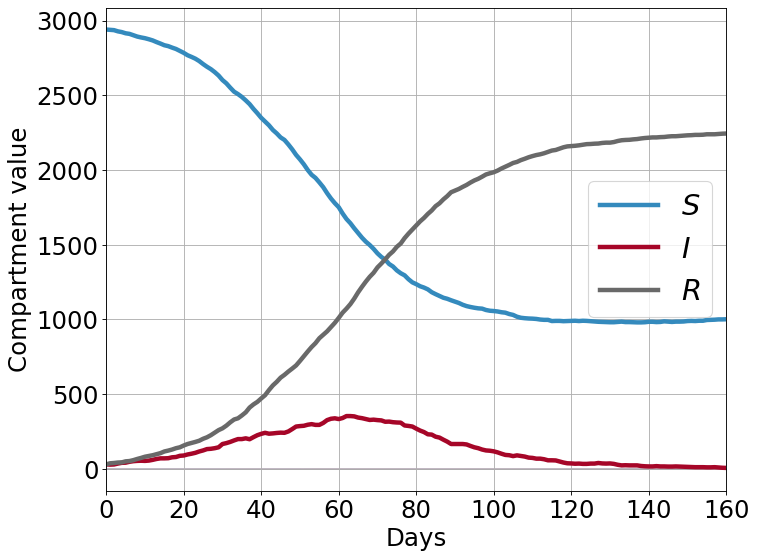

In [5]:
# plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In [6]:
# load the data and rescale to intensive variables 
Tf_inference = 100 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1
steps = 4 # number internal integration steps taken, must be an odd number 

x = (data['X'][:Nf_inference]).astype('float') 

In [8]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
beta_g = 0.05 
beta_std = 0.2 

gamma_g = 0.2
gamma_std = 0.2 

k = 0.5

# compute -log_p for the initial guess 
guessed_parameters = {
    'beta' : beta_g, 
    'gamma' : gamma_g,
    'k': k, 
}

estimator = pyross.inference.Spp(model_spec, parameters, M, Ni)

# check logp for correct parameters 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix, tangent=False)
print(logp)

# check logp for wrong parameters 
logp = estimator.obtain_minus_log_p(guessed_parameters, x, Tf_inference, contactMatrix, tangent=False)
print(logp) 

1590.7709468425405
2687.2457178813356


In [10]:
## inference 
ftol = 1e-6  # Stopping criterion for minimisation (realtive change in function value)
eps = 1e-4 
priors = {
    'beta':{
        'mean': beta_g, 
        'std': beta_std, 
        'bounds': [eps, 0.3]
    }, 
    'gamma':{
        'mean': gamma_g, 
        'std': gamma_std, 
        'bounds': [eps, 0.3]
    }
}
estimator.set_lyapunov_method('euler')
res = estimator.infer_parameters(x, Tf_inference, contactMatrix, priors, 
                                    tangent=False, 
                                    global_max_iter=20, local_max_iter=200, 
                                    global_atol=1, ftol=ftol, verbose=True)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 2 (seed=3824196417, Mon Jun 29 20:28:30 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.880107976039973e+03 1.0e+00 9.51e-01  7e-02  9e-02 0:01.3
    2     32 1.601146715576376e+03 1.3e+00 1.01e+00  6e-02  1e-01 0:02.6
    3     48 1.677104761945521e+03 1.8e+00 9.36e-01  5e-02  7e-02 0:03.8
    6     96 1.600472027160391e+03 1.1e+00 4.81e-01  2e-02  2e-02 0:07.2
   10    160 1.587779988330307e+03 1.1e+00 2.11e-01  2e-03  3e-03 0:11.7
   15    240 1.587681041967924e+03 1.2e+00 9.74e-02  4e-04  4e-04 0:17.5
   20    320 1.587674859186391e+03 1.3e+00 3.30e-02  4e-05  4e-05 0:24.4
Optimal value (global minimisation):  1587.6748591863907
Starting local minimisation...
Optimal value (local minimisation):  1587.6748370613673


In [11]:
print("True parameters:")
print(parameters)

print("\nInferred parameters:")
best_estimates = res['map_dict']
print(best_estimates)

True parameters:
{'beta': 0.1, 'gamma': 0.1, 'k': 0.5}

Inferred parameters:
{'beta': 0.09791037954744407, 'gamma': 0.09724302451368373, 'k': array([0.5, 0.5, 0.5])}


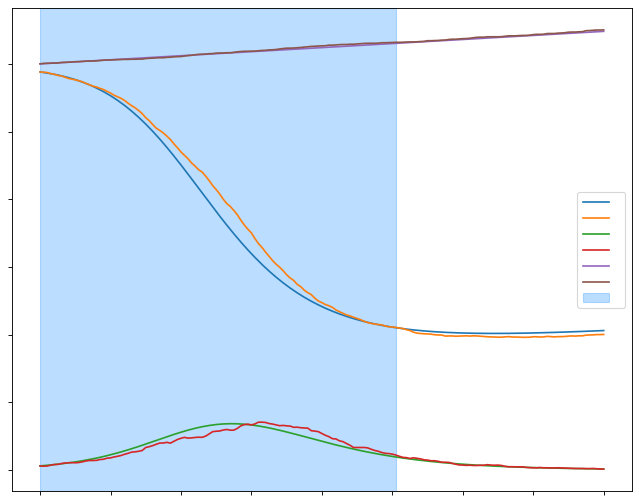

In [17]:
x = data['X']
estimator.set_det_model(best_estimates)
x_det = estimator.integrate(x[0].astype('float'), 0, Tf, Nf)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred I')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True I')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ni')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ni')
plt.axvspan(0, Nf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 